<a href="https://colab.research.google.com/github/evmorg/RB_salarycap_EPA/blob/main/RB_salarycap_EPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Best Bang for Buck?
Running Backs in the NFL - Which Team Gets Best Bang for Buck?

Over the past summer, many have debated the value of running backs (RBs) in the NFL. Two sides persist in this case: the teams (who wish to get the most on-field production out of their RBs for the least money) and the players (who wish to earn the most money possible during their careers). As a fan, I'm interested in this debate as I believe these RBs should be given as much money as possible during their careers; however, I recognize there is a competitive advantage to ensuring that teams get good production out of their RBs while spending little money on the position. In an ideal world, teams would pay their RBs well, and RBs would produce on the field.

So, how do we determine which teams are getting the best production out of their RBs for the least amount of money, relative to their team and the league, during a given year? Well there are two keys variables we can look at: the percentage of a team’s salary cap going to the RBs (i.e., salary cap percentage) and how many points an RB contributes to the team each play they touch the ball (i.e., EPA or Expected Points Added).

To access these variables, I pulled data from two sources: Spotrac (for contract data) and nfl-data-py (for player EPA data).

I started by scraping the salary cap tables from each NFL team from 2020-2023. I chose to start at 2020 because the salary structures changed with the 2020 collective bargaining agreement, and have remained in place since. You can view Sections 1 to 3 to view the preparation and processing steps needed to return data frames containing the salary data for individual RBs and the total salary data given to RBs by each team from 2020-2023.

Next, I pulled EPA data from the nfl-data-py library. You can find the preparation and processing steps for this EPA data in Section 4, with the end result being a dataset with individual RB EPA for each year, and the sum of a team’s RB EPA for each year. This dataset was then merged with the RB salary data set, which is then used in analysis.

Now that I have my final dataset, I began the analysis and data visualization in Section 5. Heat maps were used to identify the teams that spent the most on RBs, and dedicated the greatest percentage of their respective salary caps to RBs. Scatter plots were used to visualize the relationship between receiving and rushing production from each team’s RBs, as well as their respective salary cap percentage dedicated to the position. Using these scatter pots, we can best identify which teams truly got the “best bang for their buck”. Section 6 is used to summarize the results.


#Section 1 - Run once

##Mount google drive and import libs

In [90]:
# from google.colab import drive
# drive.mount('/content/drive')

from urllib.request import urlopen
from bs4 import BeautifulSoup

##Define functions

Here we are creating functions in order to write the html to a txt file. Rather than call to the website each time we reference the url, we can just use these functions to produce a txt file and execute over this continually.

This differs from the method in SpotracScrape_CapHit1.ipynb, which made calls to the website each time the scraping cell was run. It doesn't matter as much for that notebook, since we only scrape one page.

This first function called 'get_page()', will take in 'url'.
When running get_page(), the output will involve running:
* urlopen()
* BeautifulSoup() - takes in the previously created 'page'
* open() - create and open a .txt file
* str(soup) - converts soup object to string
* file.write() - writes that string into the previously created file
* file.close() - close the file

In [91]:
def get_page(url):
  page = urlopen(base_url)
  soup = BeautifulSoup(page, 'lxml')
  file = open("spotrac_urls.txt", 'w')
  file.write(str(soup))
  file.close()

This first function called 'get_team_table()', will take in 'url'.
When running get_page(), the output will involve running:
* urlopen()
* BeautifulSoup() - takes in the previously created 'page'
* find() - finds first instance of html with tag = table and class = datatable (i.e., finds the first DataTable)
* find_previous() - finds the first instance of the tag immediately before what was found in the prior find() function
* find_all() - after finding this first section using find(), finds all tr tags (i.e., rows of data in the table) within this section of html

In [92]:
def get_team_table(url):
  page = urlopen(url)
  soup = BeautifulSoup(page, 'lxml')
  title = [table for table in soup.find("table", "datatable").find_previous("title")]
  data_rows = [row for row in soup.find("table", "datatable").find_all("tr")]
  return title + data_rows

##Call to Spotrac

In [93]:
base_url = "http://www.spotrac.com/nfl/"

#Section 2 - Re-run as needed

##Get all base URLs for teams

In [94]:
get_page(base_url)

With the .txt file open, for each line, strip the white space. Then close.

the 'with open()' method allows us to easily open and close a file without having to write close().

In [95]:
with open("spotrac_urls.txt", 'r') as file:
  for line in file:
    line = line.strip()

Open the txt file, pass it through BeautifulSoup. Note, we pass the txt instead of calling to website.

Find() returns only the first element that matches the criteria of tag name = div and class = subnav-posts. The first `<div class="subnav-posts">` happens to be the group of links we want. So we don't have to use more complicated searching criteria.

In [96]:
page = open("spotrac_urls.txt", 'r')
soup = BeautifulSoup(page, "lxml")
div = soup.find("div","subnav-posts")

Create list to store links for 2023 cap.

Loop through all the div tags and find all the anchor tags. Then get the href and append to links2023 list.

In [97]:
links23 = []
links = div.find_all('a')
for link in links:
  links23.append(link.get('href'))

# links
# links23
# len(links)

Using the list comprehensions method, add strings to end of each href link in order to navigate to historical data.

In [167]:
links20 = [link + "2020/" for link in links23]
links21 = [link + "2021/" for link in links23]
links22 = [link + "2022/" for link in links23]
links23 = [link + "2023/" for link in links23]
links23

['https://www.spotrac.com/nfl/arizona-cardinals/cap/2023/2023/',
 'https://www.spotrac.com/nfl/atlanta-falcons/cap/2023/2023/',
 'https://www.spotrac.com/nfl/baltimore-ravens/cap/2023/2023/',
 'https://www.spotrac.com/nfl/buffalo-bills/cap/2023/2023/',
 'https://www.spotrac.com/nfl/carolina-panthers/cap/2023/2023/',
 'https://www.spotrac.com/nfl/chicago-bears/cap/2023/2023/',
 'https://www.spotrac.com/nfl/cincinnati-bengals/cap/2023/2023/',
 'https://www.spotrac.com/nfl/cleveland-browns/cap/2023/2023/',
 'https://www.spotrac.com/nfl/dallas-cowboys/cap/2023/2023/',
 'https://www.spotrac.com/nfl/denver-broncos/cap/2023/2023/',
 'https://www.spotrac.com/nfl/detroit-lions/cap/2023/2023/',
 'https://www.spotrac.com/nfl/green-bay-packers/cap/2023/2023/',
 'https://www.spotrac.com/nfl/houston-texans/cap/2023/2023/',
 'https://www.spotrac.com/nfl/indianapolis-colts/cap/2023/2023/',
 'https://www.spotrac.com/nfl/jacksonville-jaguars/cap/2023/2023/',
 'https://www.spotrac.com/nfl/kansas-city-chi

##Get team data

Create list with every team url from 2020-2023.

In [99]:
links_all = links20 + links21 + links22 +links23
# links_all

Create empty list team_data.

For loop to grab and append html data tables.
* get_team_table() runs using the url/href from each link of links, and pulls the html for data tables from each page.
* append() - appends each html data table as a list item onto the team_data list

In [100]:
# # test on a smaller set of links to verify that the for loop below will work
# links_test = links_all[0:3]
# team_data_test = []

# for link in links_test:
#   team_data_test.append(get_team_table(link))
# # del(team_data_test, links_test)

In [101]:
team_data = []

for link in links_all:
  team_data.append(get_team_table(link))

# len(team_data)

In [ ]:
team_data[127]

In [14]:
# # test on smaller scale of html to better understand get_team_data()
# get_team_data_test = []

# page2 = urlopen("https://www.spotrac.com/nfl/arizona-cardinals/cap/2020/")
# soup2 = BeautifulSoup(page2, 'lxml')
# # below, somewhat replicates get_team_data() to show what returns
# team_data2.append(soup2.find("table", "datatable"))

# get_team_data_test
# # del(get_team_data_test, page2, soup2)

##Get player level data

Create empty list table_data. Run nested for loop, since inner items of the list are BeautifulSoup elements.
* for every item in rows list, if find_all() tags=td exists (is not None),
* Then append what text is found via get_text() to table_data list
* Concatenate rows[0] with previously retrieved text
* Do this for every item in team_data list

In [103]:
table_data = []

#A nested for loop because inner items of the list are BeautifulSoup Elements
for rows in team_data:
  for row in rows:
    if soup.find_all("td") is not None:
      table_data.append(row.get_text() + rows[0])

In [168]:
table_data[7241]

'\nTinsley\nMitchell Tinsley\n\nWR\n$750,000\n$5,000\n-\n-\n-\n-\n-\n($135,000)\n$755,000 \n0.33\nWashington Commanders 2023 Salary Cap Table | Spotrac'

In [22]:
# # test on smaller set of html to understand the above cell a bit better
# table_data2=[]
# team_data2 = team_data[0:3]

# for rows2 in team_data:
#   for row2 in rows2:
#     if soup.find_all("td", class_ = "right xs-hide") is not None:
#       table_data2.append(row2.get_text() + title[0])

# # table_data2[2]
# del(table_data2, team_data2, row2, rows2)

Remove the \n text from each list item, append each new list item to player_data list

In [105]:
player_data = []
for row in table_data:
  player_data.append(row.split("\n"))

# len(player_data)

In [106]:
player_data[7241]

['',
 'Tinsley',
 'Mitchell Tinsley',
 '',
 'WR',
 '$750,000',
 '$5,000',
 '-',
 '-',
 '-',
 '-',
 '-',
 '($135,000)',
 '$755,000 ',
 '0.33',
 'Washington Commanders 2023 Salary Cap Table | Spotrac']

##Data wrangling

In [107]:
import pandas as pd
import numpy as np
import re

Create data frame and immediately drop rows that only contain table title.

In [ ]:
df = pd.DataFrame(player_data)
df.dropna(subset=[1], inplace=True)
# df
# df.info()

Create column headers

In [109]:
column_headers = df.loc[1].drop([0,13,14,15]).replace(['Active Players  (53)', 'Pos.', 'Restruc. Bonus', 'Misc.'], ['player', 'position', 'restructure_bonus', 'misc'])
column_headers[13] = "team_year"
column_headers

1                player
2              position
3           Base Salary
4         Signing Bonus
5          Roster Bonus
6          Option Bonus
7         Workout Bonus
8     restructure_bonus
9                  misc
10             Dead Cap
11              Cap Hit
12                Cap %
13            team_year
Name: 1, dtype: object

Remove empty columns and unecessary rows

In [110]:
# Drop empty columns
df = df.drop([0,1,3], axis=1)

# Drop first row with incorrect titles
df = df.drop(1)

# Add column headers
df.columns = column_headers
# df

# Rename columns for snake case
df = df.rename(columns={
    "Base Salary": "base_salary",
    "Signing Bonus": "signing_bonus",
    "Roster Bonus": "roster_bonus",
    "Option Bonus": "option_bonus",
    "Workout Bonus": "workout_bonus",
    "Dead Cap": "dead_cap",
    "Cap Hit": "cap_hit",
    "Cap %": "cap_percentage",
    })

# df

In [111]:
# Drop rows with '' or 'Pos.' Player value
drop_rows = df[(df['player'] == '') | (df['player'] == 'Pos.')].index
df.drop(drop_rows, inplace = True)
# df

Select currency columns for edits. Apply regex to drop symbols. Convert columns from string to float.

In [112]:
currency_columns = df.columns[2:11]
currency_columns

Index(['base_salary', 'signing_bonus', 'roster_bonus', 'option_bonus',
       'workout_bonus', 'restructure_bonus', 'misc', 'dead_cap', 'cap_hit'],
      dtype='object', name=1)

In [113]:
df[currency_columns] = (df[currency_columns].replace('\$|,|\(|\)', '', regex=True).replace('-', np.NaN, regex=True).astype(float))
df['cap_percentage'] = df['cap_percentage'].astype(float)
# df

In [114]:
# Sanity check to make sure it worked.
df['cap_hit'].sum()

18720720875.0

In [115]:
# Convert team_year to string data type
df['team_year'] = df['team_year'].astype("string")

In [116]:
# Split team_year into new columns based on ' ', and pull the 1st to 4th values
df['a'] = df['team_year'].str.split(' ',expand=True)[0]
df['b'] = df['team_year'].str.split(' ',expand=True)[1]
df['c'] = df['team_year'].str.split(' ',expand=True)[2]
df['d'] = df['team_year'].str.split(' ',expand=True)[3]

In [117]:
# Find and concatenate 3 word team names
df.a = np.where(df.b.isin(['Bay','City','Vegas','Angeles','England','Orleans','York','Francisco','Football']), df.a + ' ' + df.b, df.a)
df.b = np.where(df.b.isin(['Bay','City','Vegas','Angeles','England','Orleans','York','Francisco','Football']), df.c, df.b)
df.c = np.where(df.d.isin(['2020','2021','2022','2023']), df.d, df.c)
df = df.drop(['team_year','d'], axis = 1)
# df

In [118]:
# Concatenate a and b
df['team_name'] = df['a'] + ' ' + df['b']

# Drop columns
df = df.drop(['a','b'], axis = 1)

# Rename c to year
df = df.rename(columns={'c': 'year'})
# df

Create dictionary to store team name and abbreviation data. Merge this with main df.

In [119]:
team_name_data = {
    'team_name':[
        'Arizona Cardinals',
        'Atlanta Falcons',
        'Baltimore Ravens',
        'Buffalo Bills',
        'Carolina Panthers',
        'Chicago Bears',
        'Cincinnati Bengals',
        'Cleveland Browns',
        'Dallas Cowboys',
        'Denver Broncos',
        'Detroit Lions',
        'Green Bay Packers',
        'Houston Texans',
        'Indianapolis Colts',
        'Jacksonville Jaguars',
        'Kansas City Chiefs',
        'Las Vegas Raiders',
        'Los Angeles Chargers',
        'Los Angeles Rams',
        'Miami Dolphins',
        'Minnesota Vikings',
        'New England Patriots',
        'New Orleans Saints',
        'New York Giants',
        'New York Jets',
        'Oakland Raiders',
        'Philadelphia Eagles',
        'Pittsburgh Steelers',
        'San Francisco 49ers',
        'Seattle Seahawks',
        'Tampa Bay Buccaneers',
        'Tennessee Titans',
        'Washington Football Team',
        'Washington Commanders'
        ],
    'team_abbrev':[
        'ARI',
        'ATL',
        'BAL',
        'BUF',
        'CAR',
        'CHI',
        'CIN',
        'CLE',
        'DAL',
        'DEN',
        'DET',
        'GNB',
        'HOU',
        'IND',
        'JAX',
        'KAN',
        'LVR',
        'LAC',
        'LAR',
        'MIA',
        'MIN',
        'NWE',
        'NOR',
        'NYG',
        'NYJ',
        'LVR',
        'PHI',
        'PIT',
        'SFO',
        'SEA',
        'TAM',
        'TEN',
        'WAS',
        'WAS'
        ]
    }

In [120]:
team_abbrev_df = pd.DataFrame(team_name_data)
# team_abbrev_df
df = pd.merge(df, team_abbrev_df, on="team_name")
# df

In [121]:
df = df.sort_values(by=['team_abbrev', 'year'])
df

,player,position,base_salary,signing_bonus,roster_bonus,option_bonus,workout_bonus,restructure_bonus,misc,dead_cap,cap_hit,cap_percentage,year,team_name,team_abbrev
0,Patrick Peterson,CB,12050000.0,NaN,250000.0,NaN,250000.0,634588.0,NaN,13184588.0,13184588.0,6.71,2020,Arizona Cardinals,ARI
1,Larry Fitzgerald,WR,11000000.0,NaN,406250.0,NaN,NaN,NaN,250000.0,11000000.0,11656250.0,5.93,2020,Arizona Cardinals,ARI
2,Jordan Hicks,ILB,6000000.0,3000000.0,1000000.0,NaN,NaN,NaN,500000.0,15000000.0,10500000.0,5.34,2020,Arizona Cardinals,ARI
3,Justin Pugh,G,7250000.0,2000000.0,1171875.0,NaN,NaN,NaN,NaN,13250000.0,10421875.0,5.30,2020,Arizona Cardinals,ARI
4,Kenyan Drake,RB,8483000.0,NaN,NaN,NaN,NaN,NaN,NaN,8483000.0,8483000.0,4.32,2020,Arizona Cardinals,ARI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,K.J. Henry,DE,750000.0,89816.0,NaN,NaN,NaN,NaN,NaN,359264.0,839816.0,0.36,2023,Washington Commanders,WAS
6855,Chris Rodriguez Jr.,RB,750000.0,44422.0,NaN,NaN,NaN,NaN,NaN,177688.0,794422.0,0.34,2023,Washington Commanders,WAS
6856,Andre Jones Jr.,OLB,750000.0,25068.0,NaN,NaN,NaN,NaN,NaN,100272.0,775068.0,0.34,2023,Washington Commanders,WAS
6857,Curtis Hodges,TE,750000.0,8333.0,NaN,NaN,NaN,NaN,NaN,16667.0,758333.0,0.33,2023,Washington Commanders,WAS


#Section 3 - RB data

## RB data wrangling

Select RB position only, and keep only the following financial columns: base salary, cap %

In [122]:
rb_df = df[df['position'] == 'RB']

# Drop columns
rb_df = rb_df.drop(['position','team_name','signing_bonus','roster_bonus','option_bonus','workout_bonus','restructure_bonus','misc','dead_cap','cap_hit'], axis = 1)

# Convert year to int64
rb_df['year'] = rb_df['year'].astype(np.int64)

rb_df

,player,base_salary,cap_percentage,year,team_abbrev
4,Kenyan Drake,8483000.0,4.32,2020,ARI
29,Chase Edmonds,750000.0,0.44,2020,ARI
45,Eno Benjamin,610000.0,0.32,2020,ARI
47,Jonathan Ward,466471.0,0.24,2020,ARI
50,D.J. Foster,160588.0,0.08,2020,ARI
...,...,...,...,...,...
6786,Brian Robinson,643889.0,0.40,2022,WAS
6803,Jaret Patterson,825000.0,0.02,2022,WAS
6823,Antonio Gibson,2743000.0,1.31,2023,WAS
6838,Brian Robinson,934314.0,0.50,2023,WAS


##Select team data by year

In [124]:
# 2020 teams
rb_df_20 = rb_df[rb_df['year'] == 2020]
rb_df_20 = rb_df_20.drop('year', axis = 1)
rb_df_20 = rb_df_20.rename(columns={'base_salary': 'base_20',
                                  'cap_percentage': 'cap_perc_20'})
rb_df_20 = rb_df_20.groupby("team_abbrev").agg(
    sum_base_20 = ("base_20", "sum"),
    sum_cap_perc_20 = ("cap_perc_20","sum")
    )
# rb_df_20

In [125]:
# 2021 teams
rb_df_21 = rb_df[rb_df['year'] == 2021]
rb_df_21 = rb_df_21.drop('year', axis = 1)
rb_df_21 = rb_df_21.rename(columns={'base_salary': 'base_21',
                                  'cap_percentage': 'cap_perc_21'})
rb_df_21 = rb_df_21.groupby("team_abbrev").agg(
    sum_base_21 = ("base_21", "sum"),
    sum_cap_perc_21 = ("cap_perc_21","sum")
    )
# rb_df_21

In [126]:
# 2022 teams
rb_df_22 = rb_df[rb_df['year'] == 2022]
rb_df_22 = rb_df_22.drop('year', axis = 1)
rb_df_22 = rb_df_22.rename(columns={'base_salary': 'base_22',
                                  'cap_percentage': 'cap_perc_22'})
rb_df_22 = rb_df_22.groupby("team_abbrev").agg(
    sum_base_22 = ("base_22", "sum"),
    sum_cap_perc_22 = ("cap_perc_22","sum")
    )
# rb_df_22

In [127]:
# 2023 teams
rb_df_23 = rb_df[rb_df['year'] == 2023]
rb_df_23 = rb_df_23.drop('year', axis = 1)
rb_df_23 = rb_df_23.rename(columns={'base_salary': 'base_23',
                                  'cap_percentage': 'cap_perc_23'})
rb_df_23 = rb_df_23.groupby("team_abbrev").agg(
    sum_base_23 = ("base_23", "sum"),
    sum_cap_perc_23 = ("cap_perc_23","sum")
    )
# rb_df_23

##Merge team data frames

In [128]:
from functools import reduce

# Create list of dataframes
dfs = [rb_df_20, rb_df_21, rb_df_22, rb_df_23]

# Outer join merge of dfs on team_abbrev
team_rb_df = reduce(lambda  left,right: pd.merge(left,right,on=['team_abbrev'],
                                            how='outer'), dfs)

# Rearrange columns
team_rb_df = team_rb_df[['sum_base_20', 'sum_base_21', 'sum_base_22', 'sum_base_23', 'sum_cap_perc_20', 'sum_cap_perc_21', 'sum_cap_perc_22', 'sum_cap_perc_23']]

team_rb_df

,sum_base_20,sum_base_21,sum_base_22,sum_base_23,sum_cap_perc_20,sum_cap_perc_21,sum_cap_perc_22,sum_cap_perc_23
team_abbrev,,,,,,,,
ARI,10470059.0,3730000.0,4385000.0,7870000.0,5.40,2.28,2.49,4.85
ATL,7058000.0,3696110.0,2780000.0,5870000.0,4.60,3.36,2.00,4.53
BAL,6035000.0,2750274.0,6310858.0,2094000.0,4.03,1.39,3.99,1.93
BUF,3125000.0,3729651.0,6198333.0,3255094.0,2.05,2.53,3.32,1.84
CAR,4812059.0,1356666.0,2486667.0,2890000.0,5.68,0.82,1.70,1.91
CHI,1861489.0,3123918.0,5112218.0,4515000.0,1.00,1.85,2.34,2.45
CIN,4600000.0,7043332.0,11190000.0,3852000.0,3.04,5.41,7.11,5.00
CLE,5835190.0,3117222.0,4256674.0,2540000.0,2.93,4.98,6.15,1.22
DAL,8156765.0,2927777.0,14070000.0,11781000.0,5.71,4.17,8.98,5.12


In [130]:
team_base_df = team_rb_df[['sum_base_20','sum_base_21','sum_base_22','sum_base_23']]
team_base_df

,sum_base_20,sum_base_21,sum_base_22,sum_base_23
team_abbrev,,,,
ARI,10470059.0,3730000.0,4385000.0,7870000.0
ATL,7058000.0,3696110.0,2780000.0,5870000.0
BAL,6035000.0,2750274.0,6310858.0,2094000.0
BUF,3125000.0,3729651.0,6198333.0,3255094.0
CAR,4812059.0,1356666.0,2486667.0,2890000.0
CHI,1861489.0,3123918.0,5112218.0,4515000.0
CIN,4600000.0,7043332.0,11190000.0,3852000.0
CLE,5835190.0,3117222.0,4256674.0,2540000.0
DAL,8156765.0,2927777.0,14070000.0,11781000.0


In [131]:
team_cap_df = team_rb_df[['sum_cap_perc_20','sum_cap_perc_21','sum_cap_perc_22','sum_cap_perc_23']]
team_cap_df

,sum_cap_perc_20,sum_cap_perc_21,sum_cap_perc_22,sum_cap_perc_23
team_abbrev,,,,
ARI,5.40,2.28,2.49,4.85
ATL,4.60,3.36,2.00,4.53
BAL,4.03,1.39,3.99,1.93
BUF,2.05,2.53,3.32,1.84
CAR,5.68,0.82,1.70,1.91
CHI,1.00,1.85,2.34,2.45
CIN,3.04,5.41,7.11,5.00
CLE,2.93,4.98,6.15,1.22
DAL,5.71,4.17,8.98,5.12


##Select player data by year

In [ ]:
# 2020 players
rbs_df_20 = rb_df[rb_df['year'] == 2020]
rbs_df_20 = rbs_df_20.drop(['year'], axis = 1)
rbs_df_20 = rbs_df_20.rename(columns={'base_salary': 'base_20',
                                  'cap_percentage': 'cap_perc_20'})
# rbs_df_20

In [ ]:
# 2021 players
rbs_df_21 = rb_df[rb_df['year'] == 2021]
rbs_df_21 = rbs_df_21.drop(['year'], axis = 1)
rbs_df_21 = rbs_df_21.rename(columns={'base_salary': 'base_21',
                                  'cap_percentage': 'cap_perc_21'})
# rbs_df_21

In [133]:
# 2022 players
rbs_df_22 = rb_df[rb_df['year'] == 2022]
rbs_df_22 = rbs_df_22.drop(['year'], axis = 1)
rbs_df_22 = rbs_df_22.rename(columns={'base_salary': 'base_22',
                                  'cap_percentage': 'cap_perc_22'})
# rbs_df_22

In [134]:
# 2023 players
rbs_df_23 = rb_df[rb_df['year'] == 2023]
rbs_df_23 = rbs_df_23.drop(['year'], axis = 1)
rbs_df_23 = rbs_df_23.rename(columns={'base_salary': 'base_23',
                                  'cap_percentage': 'cap_perc_23'})
# rbs_df_23

##Merge player data frames

In [135]:
# Create list of dataframes
dfs2 = [rbs_df_20, rbs_df_21, rbs_df_22, rbs_df_23]

# Outer join merge of dfs on team_abbrev
players_rb_df = reduce(lambda  left,right: pd.merge(left,right,on=['player', 'team_abbrev'],
                                            how='outer'), dfs2)

# Rearrange columns
players_rb_df = players_rb_df[['player', 'team_abbrev', 'base_20', 'base_21', 'base_22', 'base_23',
                               'cap_perc_20', 'cap_perc_21', 'cap_perc_22', 'cap_perc_23']]

# Sort df
players_rb_df = players_rb_df.sort_values(by=['team_abbrev', 'player'])

players_rb_df

,player,team_abbrev,base_20,base_21,base_22,base_23,cap_perc_20,cap_perc_21,cap_perc_22,cap_perc_23
1,Chase Edmonds,ARI,750000.0,920000.0,NaN,NaN,0.44,0.54,NaN,NaN
191,Corey Clement,ARI,NaN,NaN,1035000.0,NaN,NaN,NaN,0.19,NaN
4,D.J. Foster,ARI,160588.0,NaN,NaN,NaN,0.08,NaN,NaN,NaN
246,Emari Demercado,ARI,NaN,NaN,NaN,750000.0,NaN,NaN,NaN,0.33
2,Eno Benjamin,ARI,610000.0,780000.0,NaN,NaN,0.32,0.42,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
287,Chris Rodriguez Jr.,WAS,NaN,NaN,NaN,750000.0,NaN,NaN,NaN,0.34
186,Jaret Patterson,WAS,NaN,660000.0,825000.0,NaN,NaN,0.34,0.02,NaN
187,Jaret Patterson,WAS,NaN,660000.0,825000.0,NaN,NaN,0.34,0.02,NaN
188,Jonathan Williams,WAS,NaN,275000.0,1035000.0,NaN,NaN,0.14,0.43,NaN


#Section 4 - NFL EPA data

Install and import nfl-data-py library

In [ ]:
%pip install nfl-data-py

In [137]:
import nfl_data_py as nfl

Import the seasonal data to access Rushing EPA, and seasonal rosters to link player_ids with names

In [138]:
seasons = range(2020,2023)
nfl_df = nfl.import_seasonal_data(seasons)
nfl_roster_df = nfl.import_seasonal_rosters(seasons)

In [139]:
# print(nfl_df.columns.tolist())
# nfl_df[['player_id','carries','rushing_epa']]

# print(nfl_roster_df.columns.tolist())

##Select EPA and player ID data

Create new dfs to isolate Rushing EPA, season, team, and player information

In [ ]:
nfl_epa_df = nfl_df[['player_id', 'season', 'carries', 'rushing_epa','receptions','receiving_epa']]
# nfl_epa_df = nfl_epa_df[nfl_epa_df['carries'] >= 100]
# nfl_epa_df

In [ ]:
# Filter for only RB
nfl_roster_df = nfl_roster_df[nfl_roster_df['position'] == 'RB']

# Select for columns to move forward with
nfl_playerid_df = nfl_roster_df[['season','team','player_name','player_id']]

# Replace team abbreviations
nfl_playerid_df['team'] = nfl_playerid_df['team'].replace(
    to_replace=['GB', 'KC', 'LA', 'LV', 'NE', 'NO', 'SF', 'TB'],
    value=['GNB', 'KAN', 'LAR', 'LVR', 'NWE', 'NOR', 'SFO', 'TAM'])

# nfl_playerid_df

In [142]:
# Merge EPA data with player IDs to create final EPA df
epa_df = pd.merge(nfl_epa_df, nfl_playerid_df, on=['player_id','season'])

# Rename columns
epa_df = epa_df.rename(columns={'player_name': 'player',
                                'team': 'team_abbrev',
                                'season': 'year'
                                })
epa_df

,player_id,year,carries,rushing_epa,receptions,receiving_epa,team_abbrev,player
0,00-0023500,2020,187,-41.306019,16,0.434209,NYJ,Frank Gore
1,00-0025394,2020,156,-12.136178,12,1.722585,DET,Adrian Peterson
2,00-0025394,2021,38,-9.864626,4,-1.277645,SEA,Adrian Peterson
3,00-0027029,2020,10,-1.928720,15,-0.595304,TAM,LeSean McCoy
4,00-0027966,2020,72,-5.569567,6,0.042044,BAL,Mark Ingram
...,...,...,...,...,...,...,...,...
488,00-0038040,2022,17,-1.512551,0,0.000000,LVR,Zamir White
489,00-0038045,2022,18,-7.110148,3,-0.151033,LAC,Isaiah Spiller
490,00-0038098,2022,10,5.737183,7,1.000219,NWE,Pierre Strong
491,00-0038120,2022,80,13.889110,19,-1.432692,NYJ,Breece Hall


##Merge EPA and RB data frames

In [143]:
# Merge
player_epa_df = pd.merge(epa_df, rb_df, on=['player', 'team_abbrev', 'year'])

# Rearrange columns
player_epa_df = player_epa_df[['player_id', 'player', 'team_abbrev', 'year',
                               'base_salary', 'cap_percentage', 'carries', 'rushing_epa',
                               'receptions', 'receiving_epa']]
player_epa_df

,player_id,player,team_abbrev,year,base_salary,cap_percentage,carries,rushing_epa,receptions,receiving_epa
0,00-0025394,Adrian Peterson,DET,2020,1050000.0,0.35,156,-12.136178,12,1.722585
1,00-0027029,LeSean McCoy,TAM,2020,1050000.0,0.37,10,-1.928720,15,-0.595304
2,00-0027966,Mark Ingram,BAL,2020,4000000.0,2.69,72,-5.569567,6,0.042044
3,00-0027966,Mark Ingram,NOR,2021,656944.0,0.35,160,-31.323441,27,-2.091120
4,00-0028063,Taiwan Jones,BUF,2020,1050000.0,0.77,0,0.000000,0,-1.027353
...,...,...,...,...,...,...,...,...,...,...
314,00-0037840,Kyren Williams,LAR,2022,582781.0,0.33,35,-4.252235,9,-1.672805
315,00-0038040,Zamir White,LVR,2022,705000.0,0.43,17,-1.512551,0,0.000000
316,00-0038045,Isaiah Spiller,LAC,2022,705000.0,0.41,18,-7.110148,3,-0.151033
317,00-0038098,Pierre Strong,NWE,2022,705000.0,0.42,10,5.737183,7,1.000219


#Section 5 - Data Viz

##Heat maps

In [144]:
import plotly.express as px

In [145]:
team_base_df = team_base_df.rename(
    columns={
        'sum_base_20': '2020',
        'sum_base_21': '2021',
        'sum_base_22': '2022',
        'sum_base_23': '2023'})

In [146]:
# team_base_df

In [147]:
team_base_heat = px.imshow(team_base_df,
                           text_auto=True,
                           aspect='auto',
                           labels=dict(x='Year', y='Team'),
                           )
team_base_heat.update_layout(title="Correlation Heatmap - Team RB Base Salaries",
                             yaxis_nticks=len(team_base_df),
                             height=800)
team_base_heat

In [148]:
team_cap_df = team_cap_df.rename(
    columns={
        'sum_cap_perc_20': '2020',
        'sum_cap_perc_21': '2021',
        'sum_cap_perc_22': '2022',
        'sum_cap_perc_23': '2023'})

In [149]:
team_cap_heat = px.imshow(team_cap_df,
                           text_auto=True,
                           aspect='auto',
                           labels=dict(x='Year', y='Team'),
                           )
team_cap_heat.update_layout(title="Correlation Heatmap - Team RB Cap Percentage",
                             yaxis_nticks=len(team_base_df),
                             height=800)
team_cap_heat

##Scatter Plots

In [150]:
import seaborn as sns
from matplotlib import pyplot as plt

###NFL Logos

In [151]:
import os
import urllib.request
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [152]:
# Pull the team description from nfl_data_py, and keep only the necessary columns in the logos DataFrame
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
# logos

In [153]:
# Initialize an empty list for the logo file paths
logo_paths = []

# Initialize an empty list for the team abbreviations
team_abbr = []

# Create a folder for the image files if it doesn't exist
if not os.path.exists("logos"):
    os.makedirs("logos")

# Pull the team logos from the URL and save them in the logos folder, save the file paths
for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

# Create a dictionary and dataframe to put logo_paths and team_abbr in
data = {'team_abbrev' : team_abbr, 'logo_path' : logo_paths}

logo_data = pd.DataFrame(data)

# Update the file path for working in Google Colab
logo_data['logo_path'] = '/content/' + logo_data['logo_path']

# logo_data

### Creating team EPA data

In [154]:
# Take player EPA df, group by year and team, find mean for data
team_mean_epa_df = player_epa_df.groupby(['year', 'team_abbrev']).agg({
    'cap_percentage': 'mean',
    'rushing_epa': 'mean',
    'receiving_epa': 'mean'})

# Remove year and team from index, move to columns
team_mean_epa_df = team_mean_epa_df.rename_axis(['year', 'team_abbrev']).reset_index()

In [156]:
# Merge team EPA data with logo data
logo_data['team_abbrev'] = logo_data['team_abbrev'].replace(
    to_replace=['GB', 'KC', 'LA', 'LV', 'NE', 'NO', 'SF', 'TB'],
    value=['GNB', 'KAN', 'LAR', 'LVR', 'NWE', 'NOR', 'SFO', 'TAM'])

team_mean_epa_df = pd.merge(team_mean_epa_df, logo_data, on=['team_abbrev'])

team_mean_epa_df

,year,team_abbrev,cap_percentage,rushing_epa,receiving_epa,logo_path
0,2020,ARI,1.270000,-3.991496,2.497960,/content/logos/ARI.tif
1,2021,ARI,0.570000,1.193368,6.942921,/content/logos/ARI.tif
2,2022,ARI,0.622500,-3.114886,-1.748898,/content/logos/ARI.tif
3,2020,ATL,1.150000,-8.800222,-1.934334,/content/logos/ATL.tif
4,2021,ATL,0.990000,-12.669800,-2.753249,/content/logos/ATL.tif
...,...,...,...,...,...,...
93,2020,TEN,0.750000,4.657477,-1.809701,/content/logos/TEN.tif
94,2021,TEN,2.000000,-4.836835,4.457478,/content/logos/TEN.tif
95,2022,TEN,1.337500,-7.656018,2.651211,/content/logos/TEN.tif
96,2021,WAS,0.346667,-7.544252,-1.104428,/content/logos/WAS.tif


In [157]:
# Create separate dfs for each year
team20_mean_epa_df = team_mean_epa_df[team_mean_epa_df['year']==2020]
team21_mean_epa_df = team_mean_epa_df[team_mean_epa_df['year']==2021]
team22_mean_epa_df = team_mean_epa_df[team_mean_epa_df['year']==2022]
team20_mean_epa_df = team20_mean_epa_df.reset_index()
team21_mean_epa_df = team21_mean_epa_df.reset_index()
team22_mean_epa_df = team22_mean_epa_df.reset_index()

###All team EPA data

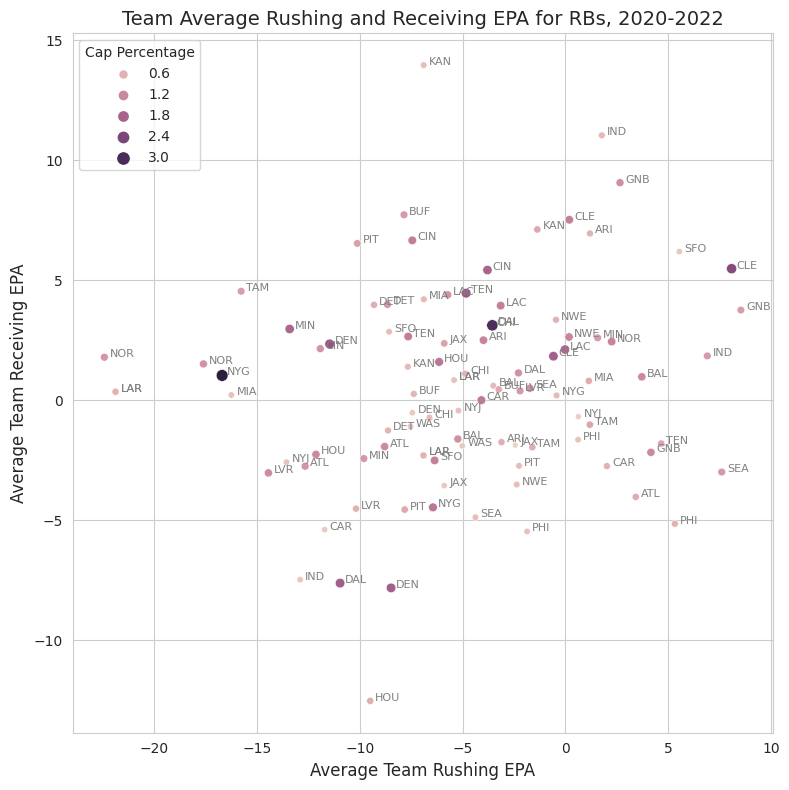

In [158]:
# Visualize all rushing and receiving EPA

# Set grid and style
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')

# Create scatter plot
team_epa_scatter = sns.scatterplot(data=team_mean_epa_df, x='rushing_epa', y='receiving_epa', hue='cap_percentage', size='cap_percentage')

# Update plot titles, axes
team_epa_scatter.set_title('Team Average Rushing and Receiving EPA for RBs, 2020-2022', fontdict={'size': 14})
team_epa_scatter.set_xlabel('Average Team Rushing EPA', fontdict={'size': 12})
team_epa_scatter.set_ylabel('Average Team Receiving EPA', fontdict={'size': 12})
team_epa_scatter.legend(title='Cap Percentage')

# Add data labels
for i, txt in enumerate(team_mean_epa_df.team_abbrev):
    team_epa_scatter.text(team_mean_epa_df.rushing_epa[i]+0.25,
                          team_mean_epa_df.receiving_epa[i],
                          txt,
                          fontsize = 8,
                          color = 'grey')

sns.move_legend(team_epa_scatter, "upper left")

plt.show()

####EPA data w/logos, no cap % data

In [159]:
# Define a function for getting the image path and loading it into the visualization
def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.075)

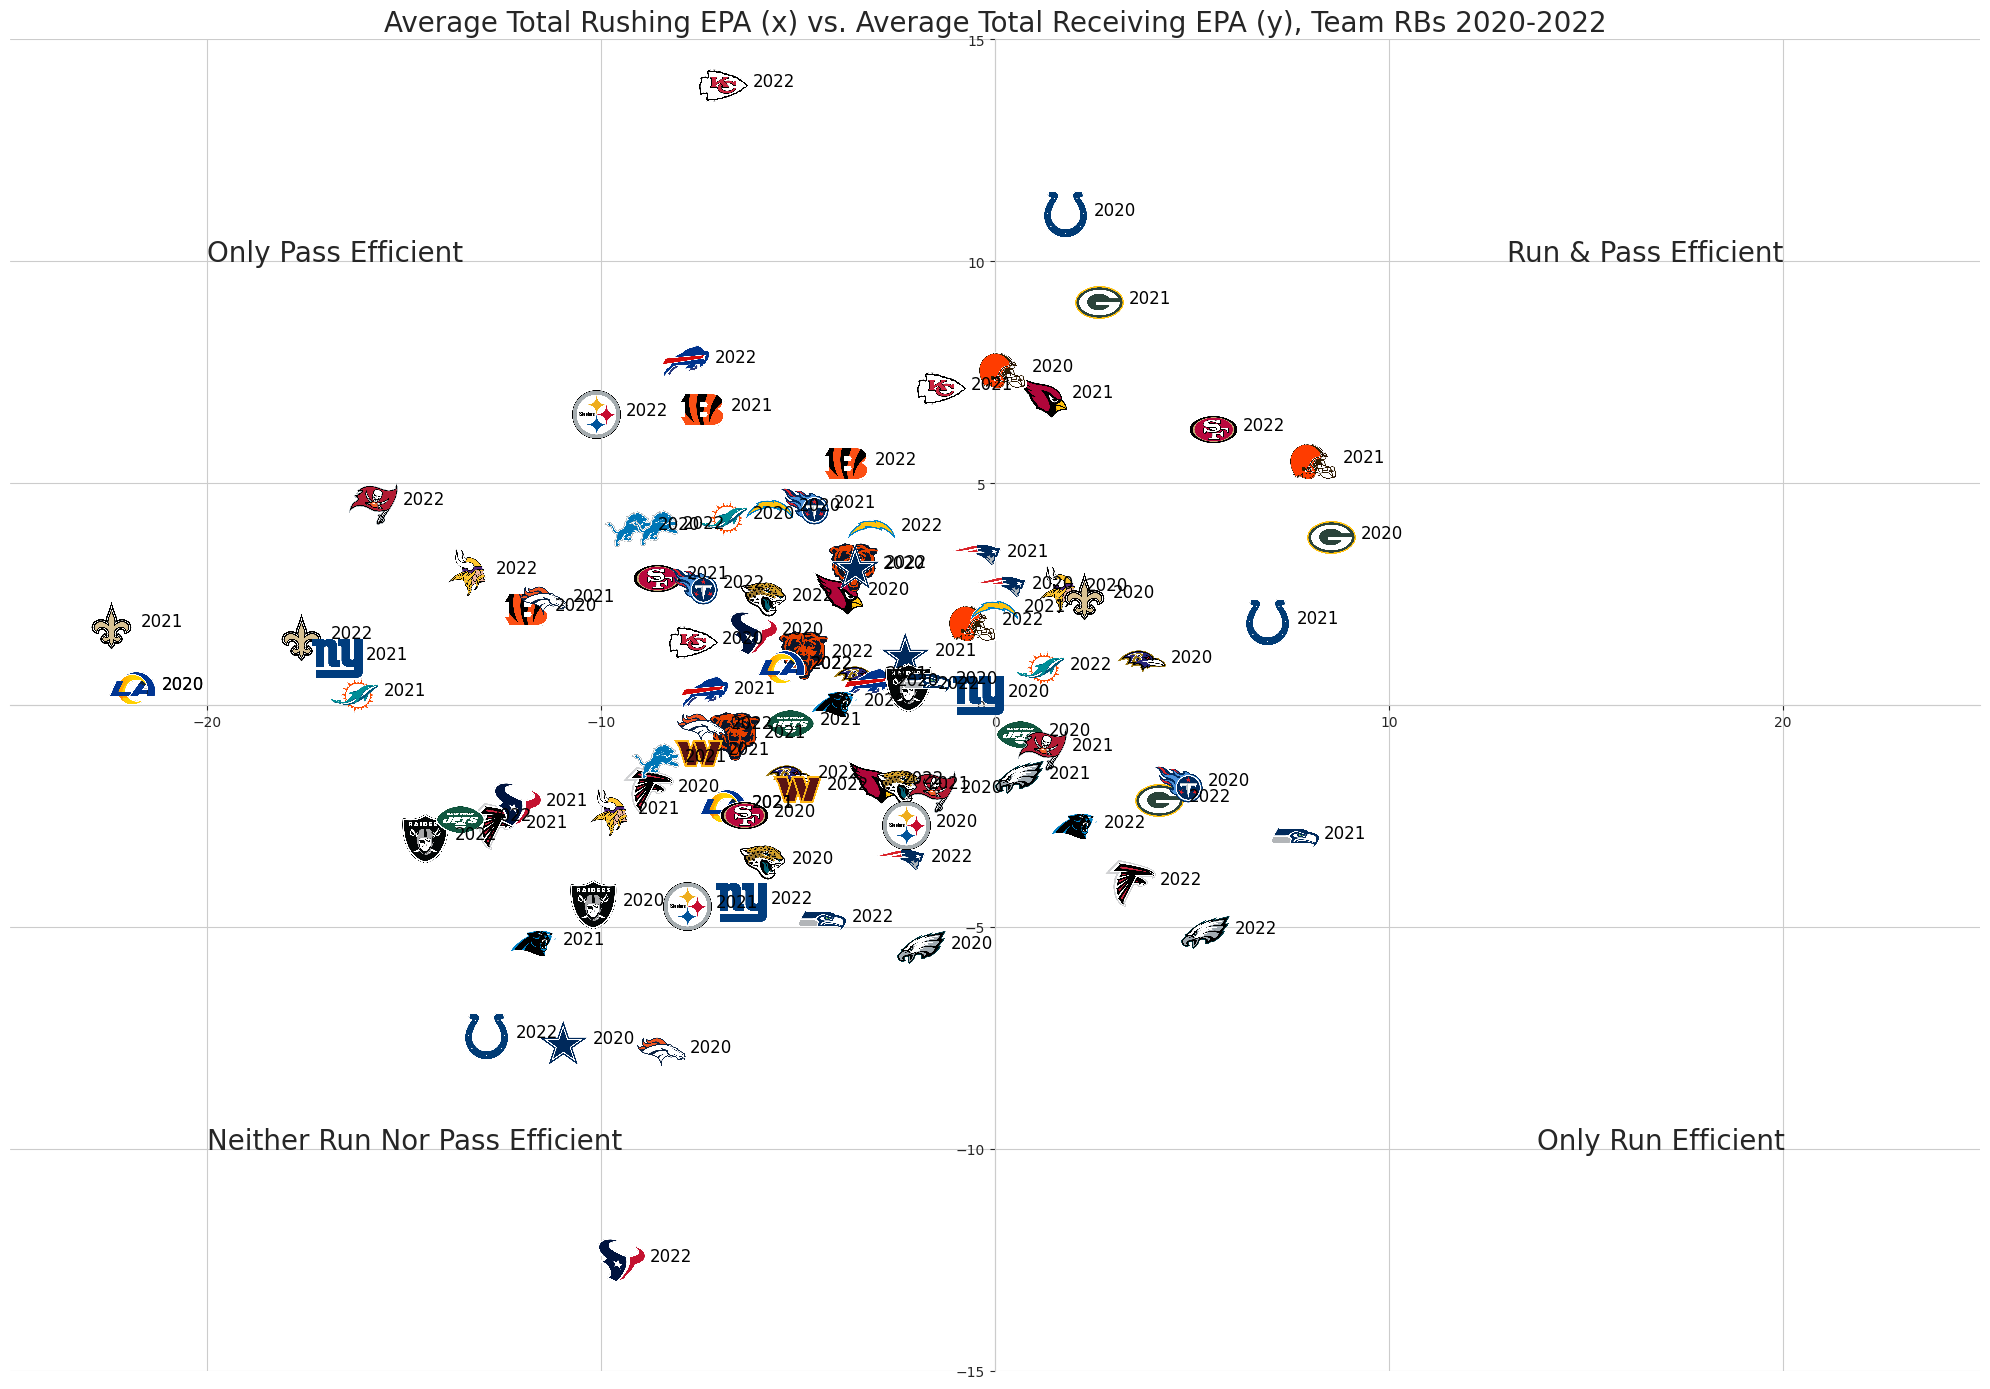

In [160]:
# Define plot size and autolayout
plt.rcParams["figure.figsize"] = [20, 14]
plt.rcParams["figure.autolayout"] = True

# Define the x and y variables
x = team_mean_epa_df['rushing_epa']
y = team_mean_epa_df['receiving_epa']

# Define the image paths
paths = team_mean_epa_df['logo_path']

# Define the plot
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
  ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
  ax.add_artist(ab)

# Plot parameters
plt.xlim(-25, 25);
plt.ylim(-15, 15);

# Move left y-axis and bottom x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Annotate the quadrants
plt.annotate("Run & Pass Efficient", (13, 10), fontsize=20)
plt.annotate("Only Pass Efficient", (-20, 10), fontsize=20)
plt.annotate("Neither Run Nor Pass Efficient", (-20, -10), fontsize=20)
plt.annotate("Only Run Efficient", (13.75, -10), fontsize=20)

# Add data labels
for i, txt in enumerate(team_mean_epa_df.year):
    plt.text(team_mean_epa_df.rushing_epa[i]+0.75,
                          team_mean_epa_df.receiving_epa[i],
                          txt,
                          fontsize = 12,
                          color = 'black')

plt.title("Average Total Rushing EPA (x) vs. Average Total Receiving EPA (y), Team RBs 2020-2022", fontdict={'fontsize':20});

### Yearly EPA data

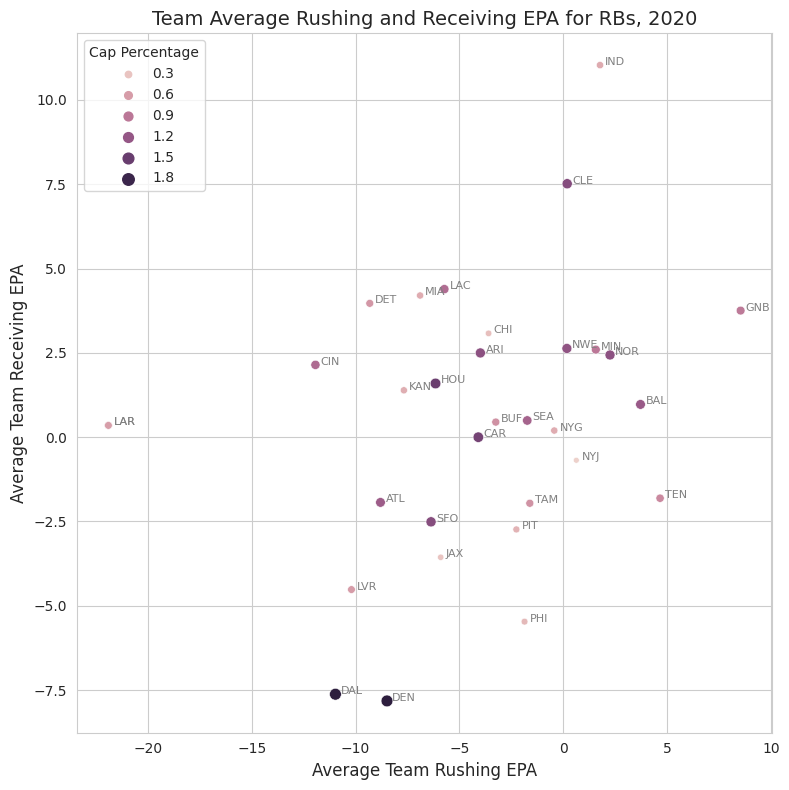

In [161]:
# Repeat process from above for each year
# 2020
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')

team20_epa_scatter = sns.scatterplot(data=team20_mean_epa_df, x='rushing_epa', y='receiving_epa', hue='cap_percentage', size='cap_percentage')

team20_epa_scatter.set_title('Team Average Rushing and Receiving EPA for RBs, 2020', fontdict={'size': 14})
team20_epa_scatter.set_xlabel('Average Team Rushing EPA', fontdict={'size': 12})
team20_epa_scatter.set_ylabel('Average Team Receiving EPA', fontdict={'size': 12})
team20_epa_scatter.legend(title='Cap Percentage')


for i, txt in enumerate(team20_mean_epa_df.team_abbrev):
    team20_epa_scatter.text(team20_mean_epa_df.rushing_epa[i]+0.25,
                          team20_mean_epa_df.receiving_epa[i],
                          txt,
                          fontsize = 8,
                          color = 'grey')

sns.move_legend(team20_epa_scatter, "upper left")

plt.show()

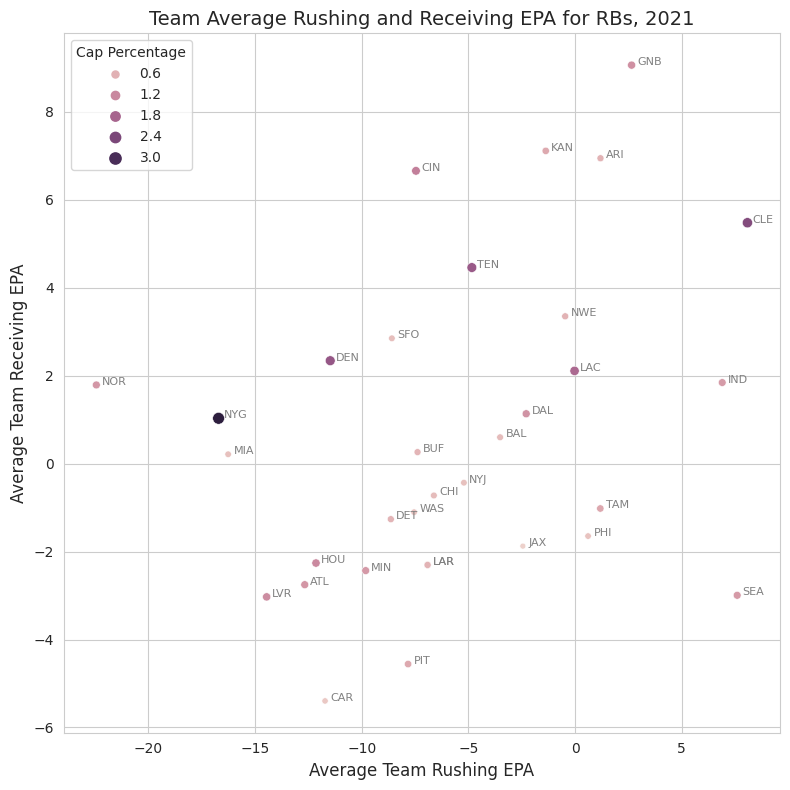

In [162]:
# Repeat process from above for each year
# 2021
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')

team21_epa_scatter = sns.scatterplot(data=team21_mean_epa_df, x='rushing_epa', y='receiving_epa', hue='cap_percentage', size='cap_percentage')

team21_epa_scatter.set_title('Team Average Rushing and Receiving EPA for RBs, 2021', fontdict={'size': 14})
team21_epa_scatter.set_xlabel('Average Team Rushing EPA', fontdict={'size': 12})
team21_epa_scatter.set_ylabel('Average Team Receiving EPA', fontdict={'size': 12})
team21_epa_scatter.legend(title='Cap Percentage')


for i, txt in enumerate(team21_mean_epa_df.team_abbrev):
    team21_epa_scatter.text(team21_mean_epa_df.rushing_epa[i]+0.25,
                          team21_mean_epa_df.receiving_epa[i],
                          txt,
                          fontsize = 8,
                          color = 'grey')

sns.move_legend(team21_epa_scatter, "upper left")

plt.show()

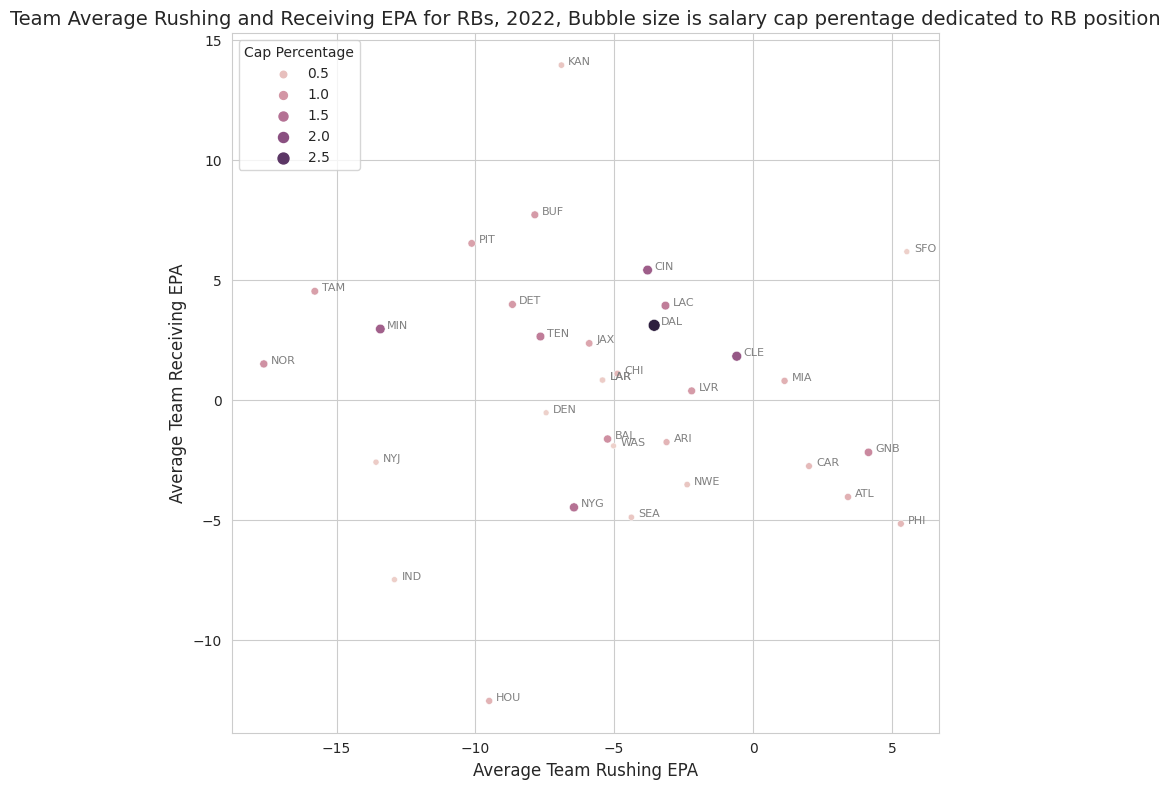

In [163]:
# Repeat process from above for each year
# 2022
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')

team22_epa_scatter = sns.scatterplot(data=team22_mean_epa_df, x='rushing_epa', y='receiving_epa', hue='cap_percentage', size='cap_percentage')

team22_epa_scatter.set_title('Team Average Rushing and Receiving EPA for RBs, 2022, Bubble size is salary cap perentage dedicated to RB position', fontdict={'size': 14})
team22_epa_scatter.set_xlabel('Average Team Rushing EPA', fontdict={'size': 12})
team22_epa_scatter.set_ylabel('Average Team Receiving EPA', fontdict={'size': 12})
team22_epa_scatter.legend(title='Cap Percentage')


for i, txt in enumerate(team22_mean_epa_df.team_abbrev):
    team22_epa_scatter.text(team22_mean_epa_df.rushing_epa[i]+0.25,
                          team22_mean_epa_df.receiving_epa[i],
                          txt,
                          fontsize = 8,
                          color = 'grey')

sns.move_legend(team22_epa_scatter, "upper left")

plt.show()

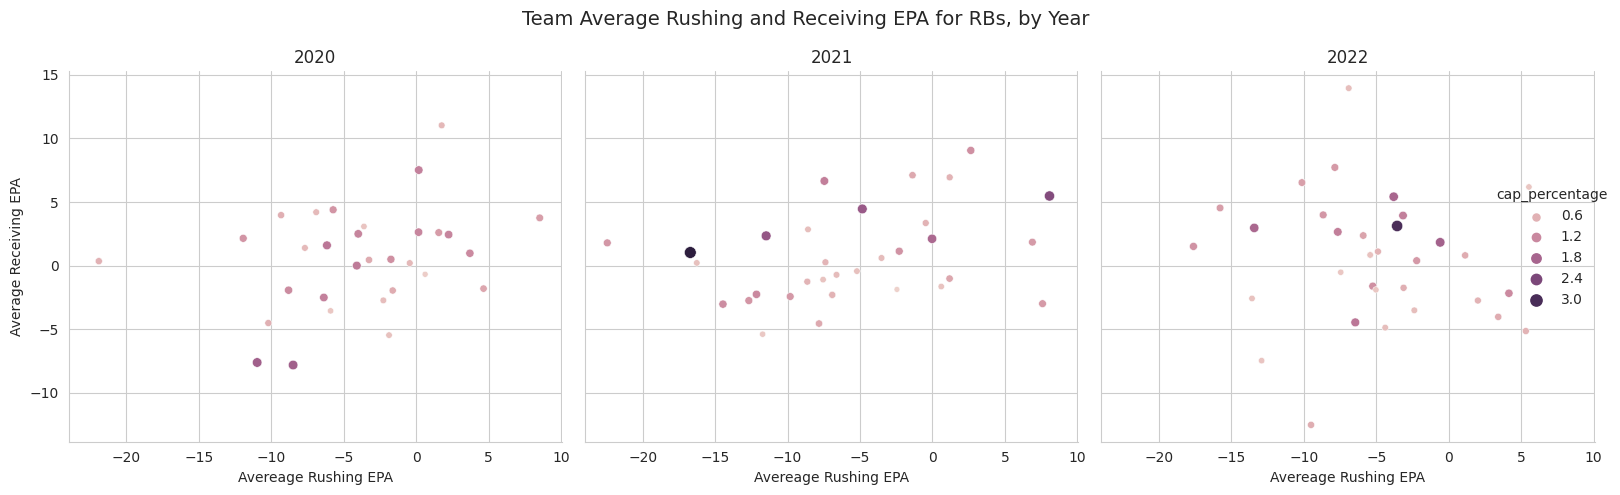

In [164]:
# Single image with scatter plots for each year

sns.set_style('whitegrid')
team_year_epa_scatter = sns.relplot(
    data=team_mean_epa_df, x='rushing_epa', y='receiving_epa',
    col='year', hue='cap_percentage', size='cap_percentage',
    kind='scatter'
)

team_year_epa_scatter.fig.subplots_adjust(top=0.87)
team_year_epa_scatter.fig.suptitle('Team Average Rushing and Receiving EPA for RBs, by Year', size=14)
team_year_epa_scatter.set_axis_labels('Avereage Rushing EPA', 'Average Receiving EPA')
team_year_epa_scatter.set_titles(col_template='{col_name}', size=12)

# ax_team_year_epa_scatter = team_year_epa_scatter.axes[0,0]
# for i,row in team_mean_epa_df.iterrows():
#     x = row['rushing_epa']
#     y = row['receiving_epa']
#     text = row['team_abbrev']
#     ax_team_year_epa_scatter.text(x+.25,y,text)

plt.show()

#Section 6 - Summary

The ploot titled "Average Total Rushing EPA (x) vs. Average Total Receiving EPA (y), Team RBs 2020-2022" best displays the results I'm aiming for. Here we see that there are a handful of teams that received positive rushing and receiving EPA from their RBs. These are:
- 2020-2021 Browns
- 2020-2021 Colts
- 2020-2021 Packers
- 2020-2021 Patriots
- 2020 Ravens
- 2020 Saints
- 2020 Vikings
- 2021 Cardinals
- 2021 Chargers
- 2022 49ers
- 2022 Dolphins

Among these teams, we can find those that received the "best bang for their buck," by looking at the 'Team Average Rushing and Receiving EPA for RBs, 2020-2022' plot. In addition to the comparison of rushing and receiving EPA, this plot uses the size of the dots/bubbles to show the percentage of the salary cap dedicated to RBs for each team. From this we can see that 2021 Cardinals (0.57%), 2020 Colts (0.49%), and 2022 49ers (0.31%) were the top 3 teams in terms of least amount of salary cap space dedicated to RBs who produced positive rushing and receiving EPA.

Future projects could include: identifying the players/teams who produced the greatest EPA per play on the lowest contract(s), and identifying if these valuable RB contracts resulted in overall team success (wins) in the NFL.  

In [165]:
# Identify cap % for teams with positive rushing and receiving EPA
team_mean_epa_df[(team_mean_epa_df['rushing_epa'] >= 0) & (team_mean_epa_df['receiving_epa'] >= 0)].sort_values(by=['cap_percentage'])


,year,team_abbrev,cap_percentage,rushing_epa,receiving_epa,logo_path
89,2022,SFO,0.306667,5.537474,6.186219,/content/logos/SF.tif
39,2020,IND,0.490000,1.767731,11.033310,/content/logos/IND.tif
1,2021,ARI,0.570000,1.193368,6.942921,/content/logos/ARI.tif
62,2022,MIA,0.665000,1.134706,0.802919,/content/logos/MIA.tif
33,2020,GNB,0.886667,8.535052,3.754029,/content/logos/GB.tif
63,2020,MIN,0.905000,1.564888,2.597333,/content/logos/MIN.tif
40,2021,IND,0.917500,6.902141,1.842845,/content/logos/IND.tif
34,2021,GNB,1.083333,2.651997,9.060418,/content/logos/GB.tif
6,2020,BAL,1.166667,3.715499,0.971381,/content/logos/BAL.tif
69,2020,NWE,1.240000,0.172588,2.631422,/content/logos/NE.tif
